# Практика № 1.

**Цель**. Познакомимся с маленьким фрагментном реального файла, содержащего данные для анализа. В этом фрагменте собраны некоторые характерные проблемы тех таблиц, которые дают заказчики для проведения анализа.


Познакомиться с некоторыми методам оценки оценки взаимосвязи бинарных факторов: расчет доверительных интервалов для относительного риска и точным тестом Фишера.

Обезличенные данные по детям с диагнозом "Острый лимфобластный лейкоз" (ОЛЛ).

https://docs.google.com/spreadsheets/d/1E8UvgeIAwBGjP6HdZTDQNmI4KX3iIk2I/edit?usp=sharing&ouid=114299830697284631791&rtpof=true&sd=true

In [ ]:
from google.colab import files
import numpy as np
import pandas as pd
from scipy import stats


#!ls
#!rm 'clinic.xlsx'
#files.upload() 
df = pd.read_excel('clinic.xlsx', index_col=0)#Data Frame

pd.set_option('display.max_rows', None)
df.shape

(200, 176)

**Задание 1**

Какие проблемы со столбцами

1. AL - AN (Курение мать, Курение отец, Курение оба)
2. BZ, BA (Селезенка <4 см, Селезенка >4см)

Где еще аналогичная проблема?

В стоблцах AZ - BK перечислены сопуствующие болезни. Здесь 1 означает наличие болезни, 0 - отсутствие.

1. Какие проблемы со стоблцом AU?
2. Какие проблемы со стоблцом AY?
3. Какие проблемы со стоблцами AV - AX? Здесь СБ1 означает наличие ровно 1 сопуствующей болезни, СБ2 означает наличие ровно 2 сопуствующих болезней... Можно ли поставить вопрос, как наличие ровно 2 сопуствующих болезней связано с риском развития полинейропатии (Факт первичного эпизода ПНП), стоблец CE?

Как решить эти проблемы?


**Задание 2**

К какой шкале относится

1. пол, стоблец C,
2. генетика, стоблец Q,
3. возраст матери при беременности, стоблец R,
4. номер беременности, от которой родился этот ребенок, стоблец S,
5. группа риска ОЛЛ, стоблец CC?

**Задание 3**

Начнем с описательных статистик.

1. Сколько мальчиков и девочек? Сколько детей с ОЛЛ типа В и типа Т?

2. Каково распределение транслокаций от t 1;19 до t 12;21?

3. Сколько мальчиков и девочек в проспективной и ретроспективной группах? Сколько детей с ОЛЛ типа В и типа Т в проспективной и ретроспективной группах?

4. Сделаем двухфакторное разбиение на группы. Дать описательные статистики по возрасту в зависимости от группы (проспективной и ретроспективной), столбец B, и факта первичного эпизода ПНП (полинейропатии), столбец CE.
То же для "Срок гестации", "Масса гр", "Длина см".

5. Сколько детей имеют ВН, МН и СН (Моторная нейропатия, Сенсорная нейропатия, Вегетативная нейропатия) во всех их возможных комбинациях? Составить таблицу и образить это на диаграмме.



In [ ]:
print(df['Пол'].value_counts())
print(df['Пол'].value_counts(normalize = True).mul(100).round(1).astype(str) + '%')

М    105
Ж     95
Name: Пол, dtype: int64
М    52.5%
Ж    47.5%
Name: Пол, dtype: object


Колонок с транслокациями с десяток (а иной задаче может быть и более 100). Повторять вручную однообразные дейстивя для всех видов транслокаций - плохая идея. Это делает решение немасштабируемым и подверженным ошибкам (пропуск нужной колонки, дублирование результатов в отчете и т. д.)

Напишем функцию, которая позволить перебрать весь диапозон колонок от заданной fromColName до заданной toColName.

In [ ]:
factorList = []

def getColumnsNames(fromColName, toColName, columnsList):
  indexStart = df.columns.get_loc(fromColName)
  indexEnd = df.columns.get_loc(toColName)
  for i in range(indexStart, indexEnd + 1):
    columnsList.append(i)

In [ ]:
getColumnsNames('t 1;19', 't 12;21', factorList)

for factor in factorList:
  columnnName = df.columns[factor]
  print(df[columnnName].value_counts(), end='\n\n')

0    190
1     10
Name: t 1;19, dtype: int64

0    199
1      1
Name: t 7;9, dtype: int64

0    199
1      1
Name: t 1;3, dtype: int64

0    198
1      2
Name: t 4;11, dtype: int64

0    199
1      1
Name: t 2;14, dtype: int64

0    199
1      1
Name: t 12;19, dtype: int64

0    195
1      5
Name: t 9;22, dtype: int64

0    161
1     39
Name: t 12;21, dtype: int64



Выбрать детей из проспективной группы и провести частотный анализ по полу можно так:

In [ ]:
df[df['Группа про/ретро'] == 1]['Пол'].value_counts()

М    66
Ж    65
Name: Пол, dtype: int64

Можно использовать метод groupby

In [ ]:
df[['Группа про/ретро', 'Пол', 'ОЛЛ']].groupby('Группа про/ретро')['Пол'].value_counts()

Группа про/ретро  Пол
0                 М      39
                  Ж      30
1                 М      66
                  Ж      65
Name: Пол, dtype: int64

Чтобы не выполнять частотный анализ вручную для всех интересующих признаков, сделаем это в цикле:

In [ ]:
colNames = ['Пол', 'ОЛЛ']
colNames.append('Группа про/ретро')

dgr = df[colNames].groupby('Группа про/ретро')

for col in colNames:
  print(dgr[col].value_counts(), end='\n\n')

Группа про/ретро  Пол
0                 М      39
                  Ж      30
1                 М      66
                  Ж      65
Name: Пол, dtype: int64

Группа про/ретро  ОЛЛ
0                 В       61
                  Т        8
1                 В      123
                  Т        8
Name: ОЛЛ, dtype: int64

Группа про/ретро  Группа про/ретро
0                 0                    69
1                 1                   131
Name: Группа про/ретро, dtype: int64



In [12]:
colNames = ['Возраст', 'Срок гестации', 'Масса гр', 'Длина см',
            'Группа про/ретро', 'Факт первичного эпизода ПНП']

In [11]:
df[colNames].groupby(['Группа про/ретро', 'Факт первичного эпизода ПНП']).describe().transpose()

Группа про/ретро                       0                         1  \
Факт первичного эпизода ПНП            0            1            0   
Возраст       count            13.000000    56.000000    25.000000   
              mean              5.076923     7.089286     6.280000   
              std               3.426892     4.810129     3.835362   
              min               3.000000     3.000000     3.000000   
              25%               3.000000     3.000000     3.000000   
              50%               4.000000     4.000000     5.000000   
              75%               5.000000    10.500000     7.000000   
              max              13.000000    17.000000    17.000000   
Срок гестации count             5.000000    29.000000    24.000000   
              mean             39.200000    36.931034    39.208333   
              std               2.167948     7.544776     1.503016   
              min              36.000000     0.000000    36.000000   
              25%              39.000000    37.000000    38.000000   
              50%              39.000000    39.000000    39.500000   
              75%              40.000000    40.000000    40.000000   
              max              42.000000    41.000000    42.000000   
Масса гр      count            12.000000    54.000000    25.000000   
              mean           3247.000000  3421.944444  3492.280000   
              std             473.131540   565.863455   317.414361   
              min            2550.000000  1370.000000  2945.000000   
              25%            2895.000000  3127.500000  3346.000000   
              50%            3275.000000  3490.000000  3420.000000   
              75%            3617.500000  3722.500000  3735.000000   
              max            4000.000000  4600.000000  4130.000000   
Длина см      count            12.000000    52.000000    25.000000   
              mean             50.583333    51.923077    52.280000   
              std               2.712206     3.661384     1.620699   
              min              45.000000    38.000000    49.000000   
              25%              49.750000    50.000000    51.000000   
              50%              50.500000    52.000000    52.000000   
              75%              52.250000    54.000000    53.000000   
              max              54.000000    59.000000    56.000000   

Группа про/ретро                          
Факт первичного эпизода ПНП            1  
Возраст       count           106.000000  
              mean              6.509434  
              std               3.573035  
              min               3.000000  
              25%               3.000000  
              50%               6.000000  
              75%               8.000000  
              max              16.000000  
Срок гестации count           104.000000  
              mean             38.528846  
              std               2.500317  
              min              26.000000  
              25%              38.000000  
              50%              39.000000  
              75%              40.000000  
              max              42.000000  
Масса гр      count           106.000000  
              mean           3370.783019  
              std             556.635009  
              min             980.000000  
              25%            3120.000000  
              50%            3455.000000  
              75%            3700.000000  
              max            4600.000000  
Длина см      count           106.000000  
              mean             51.716981  
              std               3.362977  
              min              33.000000  
              25%              51.000000  
              50%              52.000000  
              75%              54.000000  
              max              60.000000

In [8]:
colNames = ['Возраст', 'Срок гестации', 'Масса гр', 'Длина см',
            'Группа про/ретро', 'Факт первичного эпизода ПНП']


dgr = df[colNames].groupby(['Группа про/ретро', 'Факт первичного эпизода ПНП'])

for col in colNames[:-2]:
  print(col)
  display(dgr[col].describe().transpose())
  

Возраст


Группа про/ретро                     0                     1            
Факт первичного эпизода ПНП          0          1          0           1
count                        13.000000  56.000000  25.000000  106.000000
mean                          5.076923   7.089286   6.280000    6.509434
std                           3.426892   4.810129   3.835362    3.573035
min                           3.000000   3.000000   3.000000    3.000000
25%                           3.000000   3.000000   3.000000    3.000000
50%                           4.000000   4.000000   5.000000    6.000000
75%                           5.000000  10.500000   7.000000    8.000000
max                          13.000000  17.000000  17.000000   16.000000

Срок гестации


Группа про/ретро                     0                     1            
Факт первичного эпизода ПНП          0          1          0           1
count                         5.000000  29.000000  24.000000  104.000000
mean                         39.200000  36.931034  39.208333   38.528846
std                           2.167948   7.544776   1.503016    2.500317
min                          36.000000   0.000000  36.000000   26.000000
25%                          39.000000  37.000000  38.000000   38.000000
50%                          39.000000  39.000000  39.500000   39.000000
75%                          40.000000  40.000000  40.000000   40.000000
max                          42.000000  41.000000  42.000000   42.000000

Масса гр


Группа про/ретро                      0                         1             
Факт первичного эпизода ПНП           0            1            0            1
count                          12.00000    54.000000    25.000000   106.000000
mean                         3247.00000  3421.944444  3492.280000  3370.783019
std                           473.13154   565.863455   317.414361   556.635009
min                          2550.00000  1370.000000  2945.000000   980.000000
25%                          2895.00000  3127.500000  3346.000000  3120.000000
50%                          3275.00000  3490.000000  3420.000000  3455.000000
75%                          3617.50000  3722.500000  3735.000000  3700.000000
max                          4000.00000  4600.000000  4130.000000  4600.000000

Длина см


Группа про/ретро                     0                     1            
Факт первичного эпизода ПНП          0          1          0           1
count                        12.000000  52.000000  25.000000  106.000000
mean                         50.583333  51.923077  52.280000   51.716981
std                           2.712206   3.661384   1.620699    3.362977
min                          45.000000  38.000000  49.000000   33.000000
25%                          49.750000  50.000000  51.000000   51.000000
50%                          50.500000  52.000000  52.000000   52.000000
75%                          52.250000  54.000000  53.000000   54.000000
max                          54.000000  59.000000  56.000000   60.000000

In [13]:
pd.crosstab(df['ВН'], [df['МН'], df['СН']],
                      margins=True, margins_name='Итого')

МН      0       1     Итого
СН      0   1   0   1      
ВН                         
0      38  34  18  40   130
1      12  23  15  20    70
Итого  50  57  33  60   200

In [17]:
import warnings

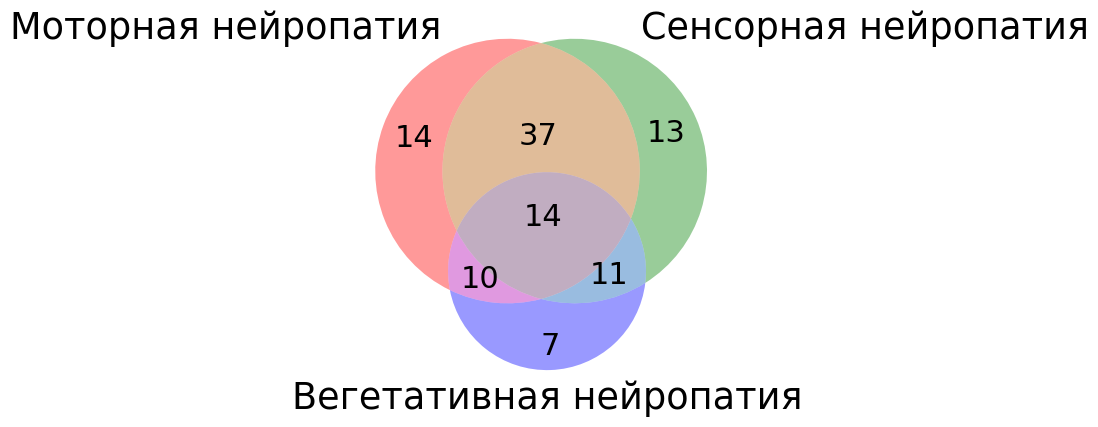

In [18]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn3

plt.figure(figsize=(5,10))
font = {'family' : 'normal',
        'size'   : 22}

plt.rc('font', **font)
#diagram = venn3((18, 34, 40, 11, 15, 24, 20))
diagram = venn3((14, 13, 37,  7, 10, 11, 14))
diagram.get_label_by_id('A').set_text('Моторная нейропатия')
diagram.get_label_by_id('B').set_text('Сенсорная нейропатия')
diagram.get_label_by_id('C').set_text('Вегетативная нейропатия')

plt.show()



Акушерские факторы риска могут иметь влияние на развитие полинейропатии.

Составтиь таблицу сопряженности 2 на 2. Исследовать факторы риска, начиная с "ОАА" (осложненный акушерский анамнез) до "Недоношенный", на Факт первичного эпизода ПНП. Использовать критерий $\chi^2$ и точный тест Фишера.

Оценить относительный риск, найти 95% доверительный интервал для относительного риска.

In [19]:
from scipy.stats.contingency import relative_risk
from scipy.stats import fisher_exact
from prettytable import PrettyTable

#Оценка относительного риска и точный тест Фишера.
#На вход подаются названия колонок, содержащих фактор риска и исход.
def safeRiskCalc(numerator, denumerator):
  if denumerator != 0:
    return str(round(numerator / denumerator*100,2))
  else:
    return '---'

def riskEstimation(factorRisk, outcome):
  expRiskOutcomeYes = len(df[(df[factorRisk] == 1) & (df[outcome] == 1)].index)
  print
  expRiskOutcomeNo = len(df[(df[factorRisk] == 1) & (df[outcome] == 0)].index)
  expRisk = expRiskOutcomeYes + expRiskOutcomeNo

  controlOutcomeYes = len(df[(df[factorRisk] == 0) & (df[outcome] == 1)].index)
  controlOutcomeNo = len(df[(df[factorRisk] == 0) & (df[outcome] == 0)].index)
  control = controlOutcomeYes + controlOutcomeNo

  pt = PrettyTable()

  cellYY = str(expRiskOutcomeYes) + ' (' + safeRiskCalc(expRiskOutcomeYes, expRisk) + ' %)'
  cellYN = str(expRiskOutcomeNo) + ' (' + safeRiskCalc(expRiskOutcomeNo, expRisk) + ' %)'
  cellNY = str(controlOutcomeYes) + ' (' + safeRiskCalc(controlOutcomeYes, control) + ' %)'
  cellNN = str(controlOutcomeNo) + ' (' + safeRiskCalc(controlOutcomeNo, control) + ' %)'

  pt.field_names = ["   ", outcome + " = Да", outcome + " = Нет", "Итого"]
  pt.add_row([factorRisk + " = Да",   cellYY, cellYN, expRisk])
  pt.add_row([factorRisk + " = Нет", cellNY, cellNN, control])
  pt.add_row(["Итого", expRiskOutcomeYes + controlOutcomeYes, expRiskOutcomeNo + controlOutcomeNo,  expRisk + control])
  print(pt)

  try:
    RR = relative_risk(expRiskOutcomeYes, expRiskOutcomeYes + expRiskOutcomeNo, controlOutcomeYes, controlOutcomeYes + controlOutcomeNo)
    print('RR =', round(RR.relative_risk, 3))
    CIlow =  round(RR.confidence_interval(confidence_level=0.95).low, 2)
    CIhigh = round(RR.confidence_interval(confidence_level=0.95).high, 2)
    print('CI = [', CIlow, '; ', CIhigh, ']', sep = '')
  except:
    print('Невозможно найти RR')
  
  fisherTest = fisher_exact([[expRiskOutcomeYes, expRiskOutcomeNo], [controlOutcomeYes, controlOutcomeNo]])
  print('Точный тест Фишера p-value = ', round(fisherTest[1], 4), '\n')

In [20]:
#Оценка влияния факторов из анамнеза на развитие ПНП
factorList = []

#df['ОЛЛ'] = df['ОЛЛ'].replace({'Т': 1, 'В': 0})
#getColumnsNames('ОЛЛ', 'ОЛЛ', factorList)
getColumnsNames('ОАА', 'Недоношенный', factorList)



outcomeList = ['Факт первичного эпизода ПНП']


df = df[df['Группа про/ретро'] == 1]
for factor in factorList:
  for outcome in outcomeList:
    columnnName = df.columns[factor]
    riskEstimation(columnnName, outcome)

+-----------+----------------------------------+-----------------------------------+-------+
|           | Факт первичного эпизода ПНП = Да | Факт первичного эпизода ПНП = Нет | Итого |
+-----------+----------------------------------+-----------------------------------+-------+
|  ОАА = Да |           41 (82.0 %)            |             9 (18.0 %)            |   50  |
| ОАА = Нет |           63 (79.75 %)           |            16 (20.25 %)           |   79  |
|   Итого   |               104                |                 25                |  129  |
+-----------+----------------------------------+-----------------------------------+-------+
RR = 1.028
CI = [0.87; 1.22]
Точный тест Фишера p-value =  0.8221 

+--------------+----------------------------------+-----------------------------------+-------+
|              | Факт первичного эпизода ПНП = Да | Факт первичного эпизода ПНП = Нет | Итого |
+--------------+----------------------------------+-----------------------------------+--

Что такое поправка Йетса на непрерывность в тесте $\chi^2$?